# Running stardate on simulated stars

Testing the code on data simulated in the Simulate_data.ipynb notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import h5py
import tqdm
import emcee

from isochrones.mist import MIST_Isochrone
from isochrones import StarModel
mist = MIST_Isochrone()

import stardate as sd
from stardate.lhf import lnprob

plotpar = {'axes.labelsize': 25,
           'font.size': 25,
           'legend.fontsize': 25,
           'xtick.labelsize': 25,
           'ytick.labelsize': 25,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load the simulated data file and plot it on an HR diagram.

In [2]:
df = pd.read_csv("data/simulated_data.csv")

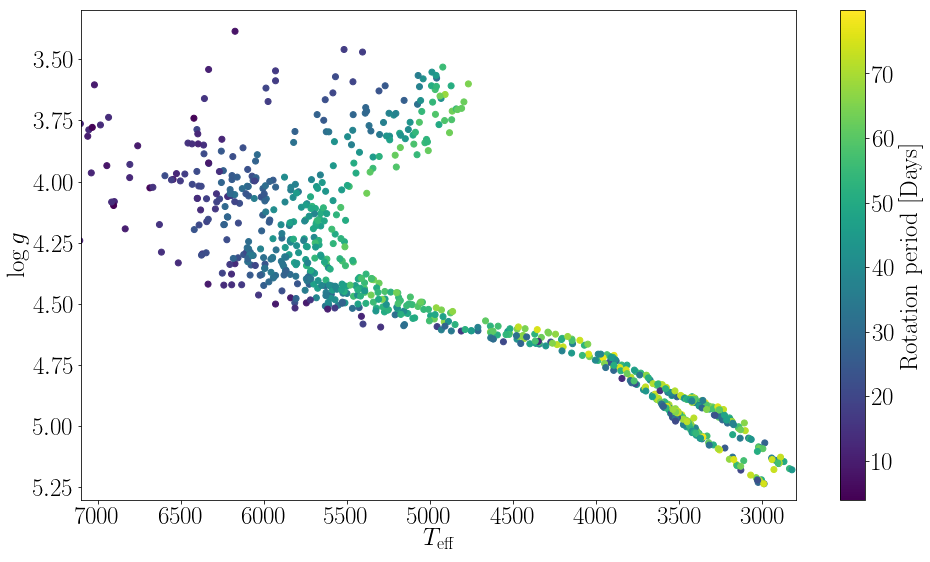

In [3]:
plt.figure(figsize=(16, 9))
plt.scatter(df.teff, df.logg, c=df.prot)
plt.ylim(5.3, 3.3)
plt.xlim(7100, 2800)
plt.xlabel("$T_{\mathrm{eff}}$")
plt.ylabel("$\log g$")
plt.colorbar(label="$\mathrm{Rotation~period~[Days]}$")

Small observational uncertainties are needed (even though the stars weren't simulated with any) in order to get a good fit.

In [4]:
teff_err = 25  # Kelvin
logg_err = .05  # dex
feh_err = .05  # dex
jmag_err = .01 # mags
hmag_err = .01  # mags
kmag_err = .01  # mags
parallax_err = .05  # milliarcseconds
prot_err = 1  # Days
BV_err = .01  # mags

# Recover stellar parameters of simulated stars

Test the likelihood function.

In [5]:
i = 0

iso_params = pd.DataFrame(dict({"teff": (df.teff[i], teff_err),
                                "logg": (df.logg[i], logg_err),
                                "feh": (df.feh[i], feh_err), 
                                "jmag": (df.jmag[i], jmag_err),
                                "hmag": (df.hmag[i], hmag_err),
                                "kmag": (df.kmag[i], kmag_err),
                                "parallax": (df.parallax[i], parallax_err)}))

mod = StarModel(mist, **iso_params)  # Set up the StarModel isochrones object.
args = [mod, df.prot[i], 1, False]  # the lnprob arguments]

lnparams = [df.eep.values[i], df.age.values[i], df.feh.values[i], 
            np.log(df.d_kpc.values[i]*1e3) + .2, df.Av.values[i]]
bad_lnprob = lnprob(lnparams, *args)
print(bad_lnprob)

lnparams = [df.eep.values[i], df.age.values[i], df.feh.values[i], 
            np.log(df.d_kpc.values[i]*1e3), df.Av.values[i]]
good_lnprob = lnprob(lnparams, *args)
print(good_lnprob)

assert bad_lnprob[0] < good_lnprob[0], "True parameters values must give a higher likelihood than wrong values"

(-158.57310437903772, -24.972577670439087)
(-25.372577670439085, -25.372577670439085)


Infer ages of the simulated stars. WARNING: this will take a long time to run!

In [7]:
# The directory where the posterior samples and result plots will be saved.
savedir = "simulation_results/iso_and_gyro"
savedir_iso = "simulation_results/iso_only"

N = len(df)
for i in range(N):
    print(i, "of", N)

    # Set up the parameter dictionary. 
    iso_params = {"teff": (df.teff[i], teff_err),
                  "logg": (df.logg[i], logg_err),
                  "feh": (df.feh[i], feh_err), 
                  "jmag": (df.jmag[i], jmag_err),
                  "hmag": (df.hmag[i], hmag_err),
                  "kmag": (df.kmag[i], kmag_err),
                  "parallax": (df.parallax[i], parallax_err)}
    
    print(iso_params)
#     assert 0
    
    # Infer an age with isochrones and gyrochronology.
    
    # Set up the star object
    star = sd.star(iso_params, df.prot[i], .01, savedir=savedir, suffix=i)
    
    # Run the MCMC
    sampler = star.fit()

    # Plot the chains and make a corner plot
    # Mass [M_sun], Age [log10(yrs)], [Fe/H] [dex], Distance [ln(pc)], A_v [R: 0-1]
    truths = [df.eep.values[i], df.age.values[i], df.feh.values[i], 
              df.d_kpc.values[i]*1e3, df.Av.values[i]]
    star.make_plots(truths, burnin=10000)
    
    # Now infer an age with isochrones only.
    
    # Set up the star object
    star_iso = sd.star(iso_params, df.prot[i], .01, savedir=savedir_iso, suffix=i)
    
    # Run the MCMC
    sampler = star_iso.fit(iso_only=True)
    
    # Plot the chains and make a corner plot
    truths = [df.eep.values[i], df.age.values[i], df.feh.values[i], 
              df.d_kpc.values[i]*1e3, df.Av.values[i]]
    star_iso.make_plots(truths, burnin=10000)

0 of 889
{'teff': (3935.5253338490475, 25), 'feh': (0.10068710224110283, 0.05), 'kmag': (11.925287016163326, 0.01), 'hmag': (12.099679314042227, 0.01), 'jmag': (12.857135267886985, 0.01), 'logg': (4.7079207777327206, 0.05), 'parallax': (4.5088413762592845, 0.05)}


  0%|          | 43/100000 [00:00<21:08, 78.78it/s]/Users/ruthangus/anaconda/lib/python3.5/site-packages/isochrones-1.2.2.dev0-py3.5.egg/isochrones/starmodel.py:523: RuntimeWarning: divide by zero encountered in log
  mass_lnprior = np.log(self.prior('mass', masses[0]))
 76%|███████▌  | 75600/100000 [39:20<12:41, 32.02it/s]    


nsteps =  75600 burnin =  10000
Plotting age posterior
Plotting production chains...
Making corner plot...


  0%|          | 44/100000 [00:00<20:10, 82.54it/s]/Users/ruthangus/anaconda/lib/python3.5/site-packages/isochrones-1.2.2.dev0-py3.5.egg/isochrones/starmodel.py:523: RuntimeWarning: divide by zero encountered in log
  mass_lnprior = np.log(self.prior('mass', masses[0]))
 57%|█████▋    | 57400/100000 [20:13<15:00, 47.32it/s]  


nsteps =  57400 burnin =  10000
Plotting age posterior
Plotting production chains...
Making corner plot...


1 of 889
{'teff': (5625.728547692234, 25), 'feh': (0.06967784904037233, 0.05), 'kmag': (10.534139337673716, 0.01), 'hmag': (10.619932711986962, 0.01), 'jmag': (11.049558827675982, 0.01), 'logg': (3.796466613860212, 0.05), 'parallax': (1.5561361100088935, 0.05)}


  0%|          | 44/100000 [00:00<19:48, 84.11it/s]/Users/ruthangus/anaconda/lib/python3.5/site-packages/isochrones-1.2.2.dev0-py3.5.egg/isochrones/starmodel.py:523: RuntimeWarning: divide by zero encountered in log
  mass_lnprior = np.log(self.prior('mass', masses[0]))
100%|██████████| 100000/100000 [10:08:16<00:00,  2.74it/s]    


nsteps =  100000 burnin =  10000
Plotting age posterior
Plotting production chains...
Making corner plot...


  0%|          | 41/100000 [00:00<21:04, 79.06it/s]/Users/ruthangus/anaconda/lib/python3.5/site-packages/isochrones-1.2.2.dev0-py3.5.egg/isochrones/starmodel.py:523: RuntimeWarning: divide by zero encountered in log
  mass_lnprior = np.log(self.prior('mass', masses[0]))
 47%|████▋     | 47200/100000 [16:38<18:36, 47.29it/s]  


nsteps =  47200 burnin =  10000
Plotting age posterior
Plotting production chains...
Making corner plot...


2 of 889
{'teff': (5839.6413911635145, 25), 'feh': (-0.017818913674203962, 0.05), 'kmag': (10.830182075384634, 0.01), 'hmag': (10.880065406618078, 0.01), 'jmag': (11.236044880695557, 0.01), 'logg': (4.247971783125218, 0.05), 'parallax': (2.572542141318514, 0.05)}


  0%|          | 44/100000 [00:00<20:20, 81.88it/s]/Users/ruthangus/anaconda/lib/python3.5/site-packages/isochrones-1.2.2.dev0-py3.5.egg/isochrones/starmodel.py:523: RuntimeWarning: divide by zero encountered in log
  mass_lnprior = np.log(self.prior('mass', masses[0]))
 49%|████▉     | 48974/100000 [17:04<13:21, 63.63it/s]  Traceback (most recent call last):
  File "/Users/ruthangus/anaconda/lib/python3.5/site-packages/emcee/ensemble.py", line 495, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/Users/ruthangus/anaconda/lib/python3.5/site-packages/stardate_code-0.0.1-py3.5.egg/stardate/lhf.py", line 116, in lnprob
    lnpr = mod.lnprior(params)
  File "/Users/ruthangus/anaconda/lib/python3.5/site-packages/isochrones-1.2.2.dev0-py3.5.egg/isochrones/starmodel.py", line 528, in lnprior
    dm_deep = self.ic.interp_value(eeps[0], age, feh, 'dm_deep')
  File "/Users/ruthangus/anaconda/lib/python3.5/site-packages/isochrones-1.2.2.dev0-py3.5.egg/isochrones/isochrone.py",

emcee: Exception while calling your likelihood function:
  params: [ 7.39633216e+02  9.63259108e+00 -2.66520546e-01  5.97056640e+00
  9.35018541e-01]
  args: [<isochrones.starmodel.StarModel object at 0x177399b70>, 40.15360540620665, 0.01, False]
  kwargs: {}
  exception:


KeyboardInterrupt: 